# Lọc nhiễu sin tự động

Trong bài thực hành trên lớp, chúng ta đã tiến hành lọc nhiễu sin thủ công dựa trên tọa độ của điểm có cường độ sáng lớn. Trong bài tập về nhà, chúng ta cần đưa ra phương án xử lý mà không cần tìm tọa độ theo cách thủ công như vậy.

Gợi ý:
- Đọc ảnh xám
- Chuyển sang miền tần số
- Tìm tọa độ các điểm có giá trị lớn nhất cục bộ (trừ điểm chính giữa)
- So sánh với ngưỡng, nếu lớn hơn thì loại bỏ điểm đó (thay bằng giá trị nhỏ nhất)
- Chuyển về ảnh bình thường, kiểm tra kết quả

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

(461, 461)


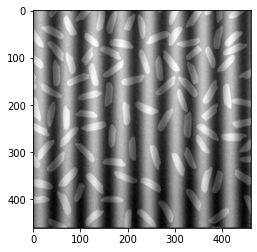

In [2]:
# read input as grayscale
img = cv2.imread('images/gao.png', 0)
print(img.shape)
plt.imshow(img, cmap='gray')
plt.show()

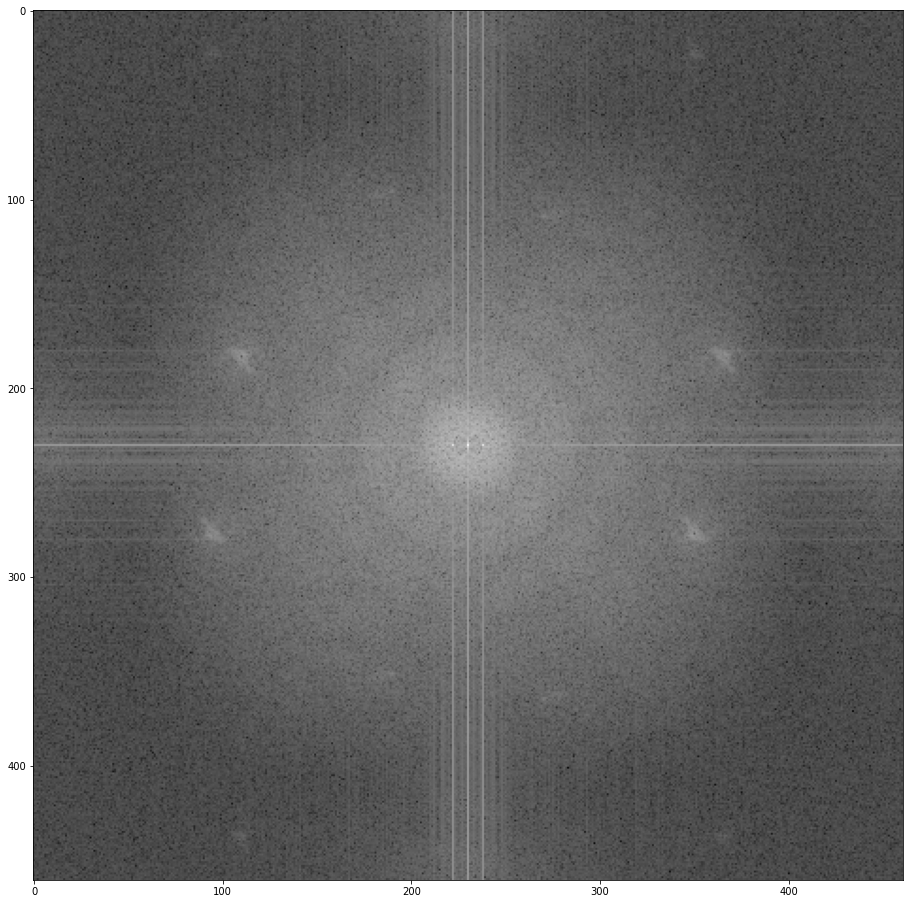

In [3]:
### YOUR CODE HERE ###
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))
plt.figure(figsize=(16,16))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.show()

Yêu cầu: Hoàn thiện hàm local_maximum

Input:
- spec: phổ của ảnh đầu vào
- win_size: kích thước cửa sổ
- thresh: ngưỡng 

Output: max_pos - tọa độ cực đại địa phương cần loại bỏ

In [4]:
def local_maximum(spec,win_size,thresh):
    ### YOUR CODE HERE

    H, W = spec.shape[:2]
    wH, wW = win_size[:2]
    max_pos = []
    for i in range(H - wH):
        for j in range(W - wW):
            mp = np.argmax(spec[i:i+wH, j:j+wW])
            max_pos.append(i * W + j + mp)
    max_pos = [(mp // W, mp % W) for mp in max_pos]
    max_pos = [(y, x) for (y, x) in max_pos if spec[y, x] > thresh]

    ### YOUR CODE HERE
    return max_pos

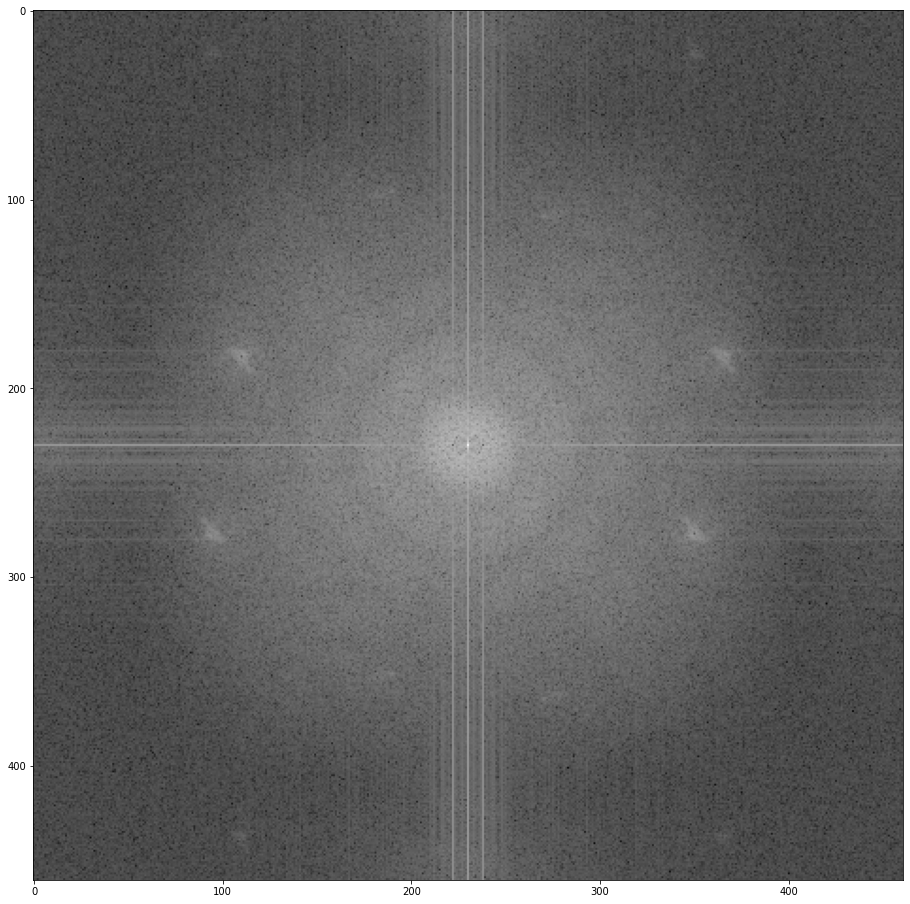

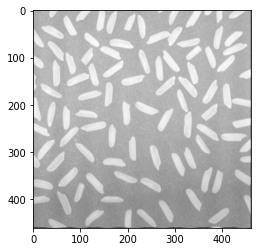

In [5]:
### YOUR CODE HERE
max_pos = local_maximum(magnitude_spectrum, (5, 5), 300)
new_dft_shift = np.copy(dft_shift)
for (y, x) in max_pos:
    if (y, x) != (new_dft_shift.shape[0] // 2, new_dft_shift.shape[1] // 2):
        new_dft_shift[y, x] = 255
new_magnitude_spectrum = 20*np.log(cv2.magnitude(new_dft_shift[:,:,0],new_dft_shift[:,:,1]))
plt.figure(figsize=(16,16))
plt.imshow(new_magnitude_spectrum, cmap = 'gray')
plt.show()

back_ishift = np.fft.ifftshift(new_dft_shift)
img_back = cv2.idft(back_ishift)
img_back = cv2.magnitude(img_back[:,:,0], img_back[:, :, 1])
img_back = cv2.normalize(img_back, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
plt.imshow(img_back, cmap='gray')
plt.show()

# Xây dựng chuỗi xử lý nhiễu

Yêu cầu: Xây dựng một chuỗi xử lý chung cho nhiều loại nhiễu khác nhau, cần kết hợp các chiến thuật đã học một cách hợp lý, có thể thay đổi tham số truyền vào

## Ảnh cần xử lý

In [6]:
import cv2
import matplotlib.pyplot as plt
import os

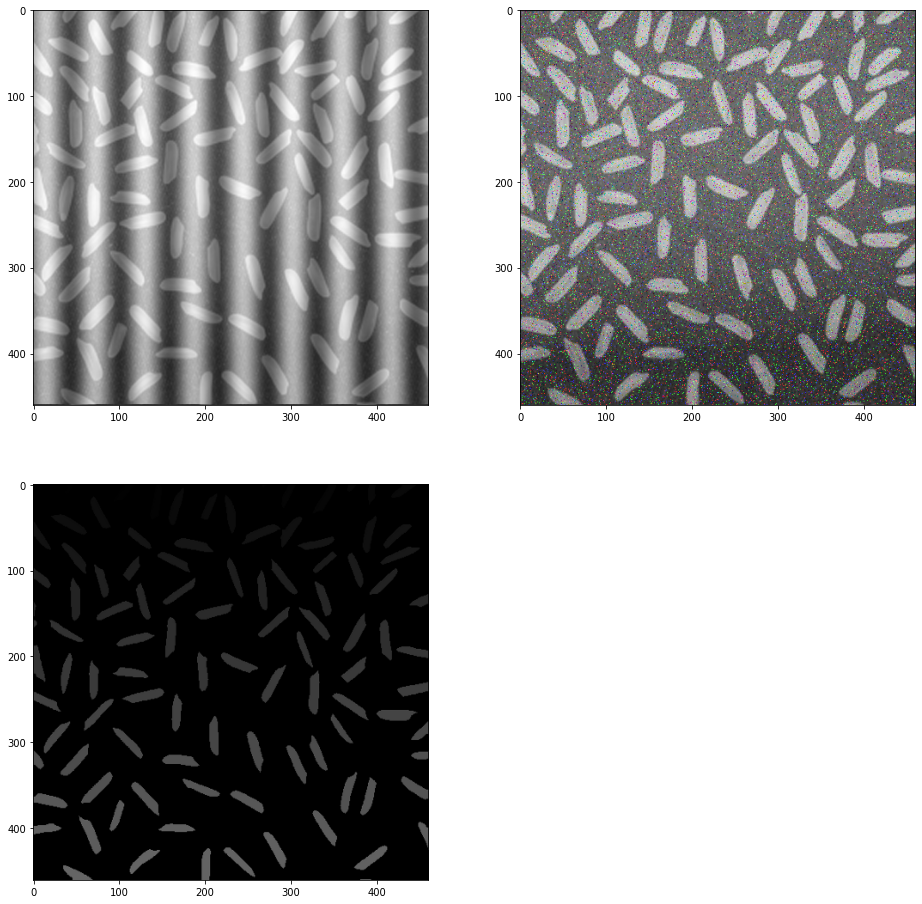

In [7]:
img_names = os.listdir('images/')
plt.figure(figsize=(16, 16)) 
for i, img_name in enumerate(img_names):
    img = cv2.imread(os.path.join('images/', img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # for showing purpose
    plt.subplot(2,2,i+1)
    plt.imshow(img) 
plt.show()

In [17]:
def gamma_correction(img, gamma):
    img = ((img/255) ** (gamma) * 255).astype(np.uint8)
    return img

def denoise(img_name, gamma=1):
    ### YOUR CODE HERE
    img = cv2.imread(os.path.join('images/', img_name), 0)
    dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))
    max_pos = local_maximum(magnitude_spectrum, (5, 5), 300)
    new_dft_shift = np.copy(dft_shift)
    for (y, x) in max_pos:
        if (y, x) != (new_dft_shift.shape[0] // 2, new_dft_shift.shape[1] // 2):
            new_dft_shift[y, x] = 255

    back_ishift = np.fft.ifftshift(new_dft_shift)
    img_back = cv2.idft(back_ishift)
    img_back = cv2.magnitude(img_back[:,:,0], img_back[:, :, 1])
    img_back = cv2.normalize(img_back, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    img_back = cv2.medianBlur(img_back, 5)
    if gamma < 1:
        img_back = gamma_correction(img_back, gamma)
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(img_back, cmap='gray')
    plt.show()
    return img_back

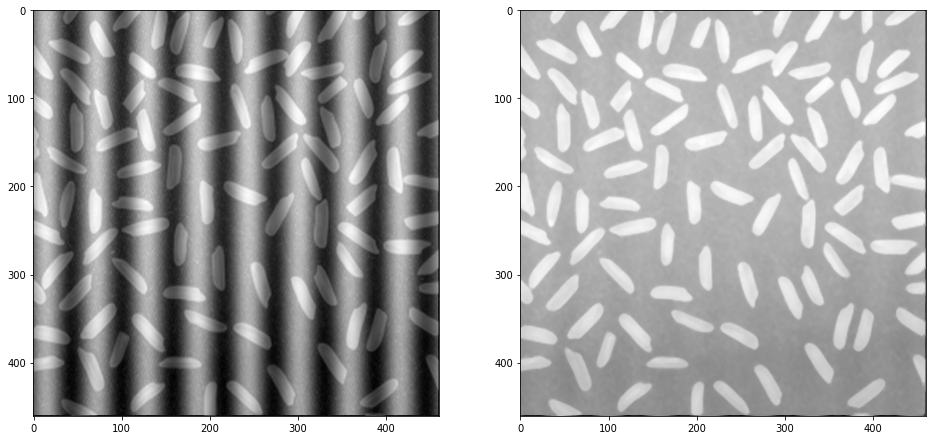

array([[176, 174, 171, ..., 180, 177,  91],
       [174, 173, 172, ..., 179, 176,  95],
       [172, 173, 172, ..., 178, 176,  97],
       ...,
       [140, 140, 140, ..., 147,  96,  66],
       [138, 139, 139, ..., 107,  79,  64],
       [ 58,  58,  58, ...,  96,  66,  64]], dtype=uint8)

In [13]:
denoise('gao.png',1)

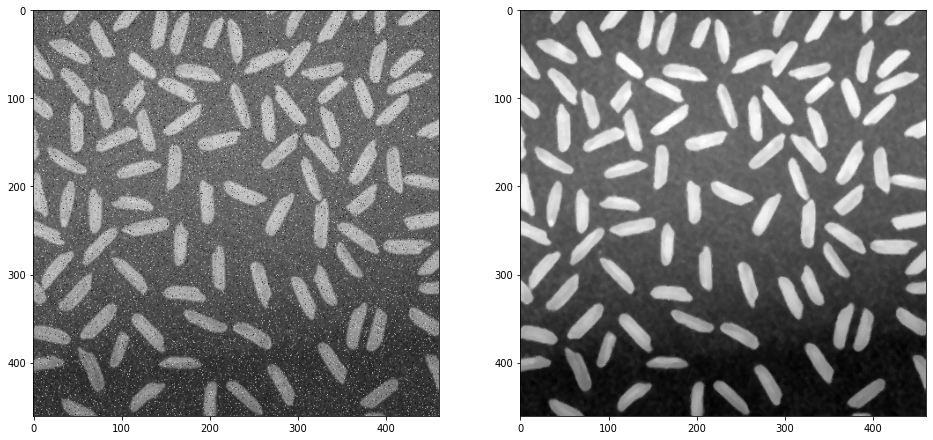

array([[106, 101,  98, ...,  96,  92,  92],
       [101, 100,  99, ...,  96,  93,  92],
       [100, 100, 100, ...,  95,  94,  93],
       ...,
       [ 55,  55,  52, ...,  56,  55,  54],
       [ 55,  54,  52, ...,  56,  54,  53],
       [ 55,  54,  52, ...,  61,  54,  50]], dtype=uint8)

In [14]:
denoise('gao2.png',1)

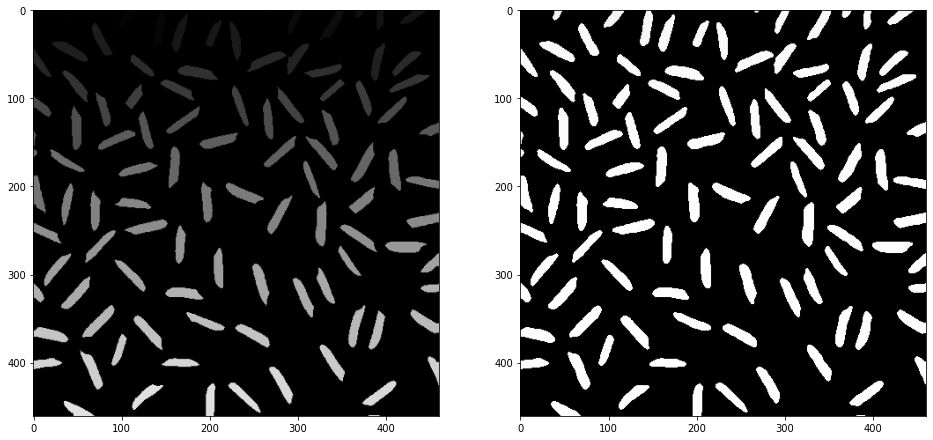

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [18]:
denoise('gao3.png',0.01)